In [1]:
# Section 1: 기본 설정 & State 개념
# ============================================================================

import os
from getpass import getpass
import json
from datetime import datetime
from typing import Literal, Annotated, List
from typing_extensions import TypedDict, NotRequired

# OpenAI API Key 설정
if not os.getenv("OPENAI_API_KEY"):
    print("🔑 OPENAI_API_KEY 입력 필요")
    key = getpass("API Key: ").strip()
    if key:
        os.environ["OPENAI_API_KEY"] = key
        print("✅ API Key 설정 완료")
else:
    print("✅ API Key 확인됨")


🔑 OPENAI_API_KEY 입력 필요
✅ API Key 설정 완료


In [2]:
# State 정의: 그래프에서 노드 간 전달되는 데이터 구조
# ----------------------------------------------------------------------------

from langchain_core.messages import AnyMessage, AIMessage
from langgraph.graph.message import add_messages
import operator


class WeatherState(TypedDict):
    """날씨 기반 추천 봇의 상태"""
    # 입력 정보
    location: str  # 위치
    date: str  # 날짜
    
    # 분석 결과
    temperature: NotRequired[float]  # 온도 (°C)
    weather_condition: NotRequired[str]  # 날씨 상태
    recommendation: NotRequired[str]  # 추천 결과
    
    # 로깅 및 메시징
    logs: Annotated[List[str], operator.add]
    messages: Annotated[List[AnyMessage], add_messages]


# 헬퍼 함수들
def log(msg: str) -> dict:
    """로그 추가"""
    timestamp = datetime.now().strftime("%H:%M:%S")
    return {"logs": [f"[{timestamp}] {msg}"]}


def say(msg: str) -> dict:
    """AI 메시지 추가"""
    return {"messages": [AIMessage(content=msg)]}


def to_json(obj) -> str:
    """JSON 출력용 헬퍼"""
    from langchain_core.messages import BaseMessage
    from langchain_core.messages.base import message_to_dict
    
    if isinstance(obj, BaseMessage):
        return message_to_dict(obj)
    if isinstance(obj, (list, tuple)) and obj and all(isinstance(m, BaseMessage) for m in obj):
        return [message_to_dict(m) for m in obj]
    if isinstance(obj, (datetime)):
        return obj.isoformat()
    return str(obj)


print("✅ Section 1 완료: 기본 설정 및 State 정의")


✅ Section 1 완료: 기본 설정 및 State 정의



📊 그래프 구조:


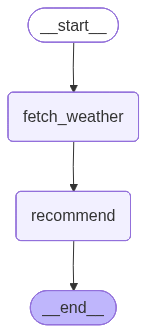


🧪 테스트:
{
  "temperature": 34.7,
  "condition": "cloudy",
  "recommendation": "34.7°C, cloudy → 반팔, 얇은 옷",
  "logs": [
    "[03:42:28] 날씨 조회: 서울 - 34.7°C, cloudy",
    "[03:42:28] 추천: 34.7°C, cloudy → 반팔, 얇은 옷"
  ]
}

✅ Section 2 완료: 첫 번째 그래프


In [3]:
# Section 2: 첫 번째 그래프 만들기
# ============================================================================

from random import uniform, choice
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# 노드 1: 날씨 데이터 수집
def fetch_weather(state: WeatherState) -> dict:
    """날씨 정보를 가져오는 노드 (실제로는 API 호출)"""
    temp = round(uniform(-5, 35), 1)
    conditions = ["sunny", "cloudy", "rainy", "snowy"]
    condition = choice(conditions)
    
    return {
        "temperature": temp,
        "weather_condition": condition,
        **log(f"날씨 조회: {state['location']} - {temp}°C, {condition}")
    }


# 노드 2: 규칙 기반 추천
def recommend_outfit(state: WeatherState) -> dict:
    """온도와 날씨에 따라 옷차림 추천"""
    temp = state.get("temperature", 20)
    condition = state.get("weather_condition", "sunny")
    
    # 온도 기반 추천
    if temp < 5:
        outfit = "두꺼운 패딩, 목도리, 장갑"
    elif temp < 10:
        outfit = "코트, 니트"
    elif temp < 20:
        outfit = "자켓, 긴팔"
    else:
        outfit = "반팔, 얇은 옷"
    
    # 날씨 추가 고려
    if condition == "rainy":
        outfit += " + 우산"
    elif condition == "snowy":
        outfit += " + 방수 신발"
    
    recommendation = f"{temp}°C, {condition} → {outfit}"
    
    return {
        "recommendation": recommendation,
        **log(f"추천: {recommendation}"),
        **say(f"오늘 날씨는 {temp}°C이고 {condition}입니다. {outfit}을(를) 추천합니다!")
    }


# 그래프 구성
builder = StateGraph(WeatherState)
builder.add_node("fetch_weather", fetch_weather)
builder.add_node("recommend", recommend_outfit)

builder.add_edge(START, "fetch_weather")
builder.add_edge("fetch_weather", "recommend")
builder.add_edge("recommend", END)

# 컴파일 및 시각화
weather_graph_v1 = builder.compile()
print("\n📊 그래프 구조:")
display(Image(weather_graph_v1.get_graph().draw_mermaid_png()))

# 실행
print("\n🧪 테스트:")
result = weather_graph_v1.invoke({
    "location": "서울",
    "date": "2025-01-15",
    "logs": [],
    "messages": []
})

print(json.dumps({
    "temperature": result.get("temperature"),
    "condition": result.get("weather_condition"),
    "recommendation": result.get("recommendation"),
    "logs": result.get("logs", [])
}, ensure_ascii=False, indent=2))

print("\n✅ Section 2 완료: 첫 번째 그래프")



📊 LLM 통합 그래프:


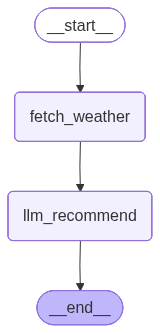


🧪 LLM 추천 테스트:

결과:
🎨 두꺼운 패딩 점퍼와 니트 스웨터, 그리고 보온성이 좋은 기모 안감의 청바지 또는 슬랙스를 추천합니다.
💡 이유: 부산의 현재 기온이 6.4°C로 쌀쌀하고 눈이 오는 날씨이므로 따뜻하고 방한 기능이 뛰어난 옷차림이 필요합니다. 패딩 점퍼는 눈과 추위를 막아주며, 니트 스웨터는 보온성을 높여줍니다. 기모 안감 바지는 체온을 유지하는 데 도움을 줍니다.
👜 준비물: 두꺼운 장갑, 넥워머 또는 목도리, 방한용 모자, 미끄럼 방지 기능이 있는 부츠

✅ Section 3 완료: LLM 통합


In [4]:
# Section 3: LLM 통합 & Tool Calling
# ============================================================================

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool


# 데이터 모델
class OutfitRecommendation(BaseModel):
    """LLM이 반환할 추천 구조"""
    outfit: str = Field(..., description="추천 옷차림")
    reason: str = Field(..., description="추천 이유")
    accessories: List[str] = Field(default_factory=list, description="필요한 악세서리")


# LLM 기반 추천 노드
def llm_recommend_outfit(state: WeatherState) -> dict:
    """LLM을 사용한 지능형 추천"""
    temp = state.get("temperature", 20)
    condition = state.get("weather_condition", "sunny")
    location = state.get("location", "unknown")
    
    # LLM에게 추천 요청
    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)
    structured_llm = llm.with_structured_output(OutfitRecommendation)
    
    prompt = PromptTemplate(
        template=(
            "당신은 패션 전문가입니다.\n\n"
            "위치: {location}\n"
            "온도: {temperature}°C\n"
            "날씨: {condition}\n\n"
            "위 정보를 바탕으로 오늘 추천하는 옷차림을 제안해주세요.\n"
            "한국어로 자연스럽게 설명해주세요."
        ),
        input_variables=["location", "temperature", "condition"]
    )
    
    chain = prompt | structured_llm
    
    try:
        result = chain.invoke({
            "location": location,
            "temperature": temp,
            "condition": condition
        })
        
        recommendation_text = (
            f"🎨 {result.outfit}\n"
            f"💡 이유: {result.reason}\n"
            f"👜 준비물: {', '.join(result.accessories) if result.accessories else '없음'}"
        )
        
        return {
            "recommendation": recommendation_text,
            **log(f"LLM 추천 완료"),
            **say(recommendation_text)
        }
        
    except Exception as e:
        return {
            "recommendation": "추천 실패",
            **log(f"LLM 오류: {e}")
        }


# 새 그래프: LLM 버전
builder_v2 = StateGraph(WeatherState)
builder_v2.add_node("fetch_weather", fetch_weather)
builder_v2.add_node("llm_recommend", llm_recommend_outfit)

builder_v2.add_edge(START, "fetch_weather")
builder_v2.add_edge("fetch_weather", "llm_recommend")
builder_v2.add_edge("llm_recommend", END)

weather_graph_v2 = builder_v2.compile()

print("\n📊 LLM 통합 그래프:")
display(Image(weather_graph_v2.get_graph().draw_mermaid_png()))

# 실행
print("\n🧪 LLM 추천 테스트:")
result = weather_graph_v2.invoke({
    "location": "부산",
    "date": "2025-01-15",
    "logs": [],
    "messages": []
})

print(f"\n결과:\n{result.get('recommendation', 'N/A')}")

print("\n✅ Section 3 완료: LLM 통합")



🤖 ReAct Agent 생성:


C:\Users\woong\AppData\Local\Temp\ipykernel_71920\3881806078.py:98: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(llm, tools=tools, prompt=system_prompt)


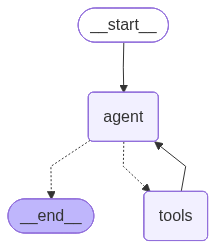


🧪 Agent 테스트:

🤖 Agent: 서울은 현재 기온 4.3도에 흐린 날씨로 다소 쌀쌀합니다. 패딩이나 두꺼운 코트를 입고 나가시는 것이 좋겠습니다. 따뜻하게 입고 외출하세요!

✅ Section 4 완료: ReAct Agent


In [5]:
# Section 4: ReAct Agent 패턴
# ============================================================================

from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage


# Tool 정의: 날씨 조회
@tool
def get_weather(location: str) -> str:
    """
    특정 위치의 현재 날씨를 조회합니다.
    
    Args:
        location: 조회할 위치 (예: "서울", "부산")
    
    Returns:
        날씨 정보 JSON 문자열
    """
    temp = round(uniform(-5, 35), 1)
    condition = choice(["맑음", "흐림", "비", "눈"])
    humidity = round(uniform(30, 90), 0)
    
    weather_data = {
        "location": location,
        "temperature": temp,
        "condition": condition,
        "humidity": humidity,
        "feels_like": temp - 2 if condition == "흐림" else temp
    }
    
    return json.dumps(weather_data, ensure_ascii=False)


# Tool 정의: 옷차림 추천
@tool
def recommend_clothing(temperature: float, condition: str, activity: str = "일상") -> str:
    """
    온도와 날씨, 활동에 맞는 옷차림을 추천합니다.
    
    Args:
        temperature: 기온 (°C)
        condition: 날씨 상태 (맑음, 흐림, 비, 눈)
        activity: 활동 종류 (일상, 운동, 외출)
    
    Returns:
        추천 옷차림 설명
    """
    # 온도 기반 기본 추천
    if temperature < 5:
        base = "패딩, 두꺼운 코트"
    elif temperature < 10:
        base = "코트, 니트, 긴바지"
    elif temperature < 20:
        base = "자켓, 긴팔 티셔츠"
    else:
        base = "반팔, 얇은 옷"
    
    # 날씨 추가
    weather_items = []
    if condition == "비":
        weather_items.append("우산")
    elif condition == "눈":
        weather_items.append("방수 부츠")
    
    # 활동 추가
    activity_items = []
    if activity == "운동":
        activity_items.append("운동화, 땀복")
    elif activity == "외출":
        activity_items.append("편한 신발")
    
    recommendation = {
        "base_outfit": base,
        "weather_items": weather_items,
        "activity_items": activity_items,
        "tip": f"{temperature}°C는 {'추운' if temperature < 10 else '따뜻한'} 날씨입니다."
    }
    
    return json.dumps(recommendation, ensure_ascii=False)


# ReAct Agent 생성
def create_weather_agent():
    """날씨 기반 추천 ReAct Agent"""
    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
    tools = [get_weather, recommend_clothing]
    
    system_prompt = """당신은 친절한 날씨 도우미입니다.

사용자가 위치를 말하면:
1. get_weather 도구로 날씨를 확인하세요
2. recommend_clothing 도구로 옷차림을 추천하세요
3. 결과를 자연스러운 한국어로 설명하세요

간결하고 실용적으로 답변하세요."""
    
    agent = create_react_agent(llm, tools=tools, prompt=system_prompt)
    return agent


# Agent 실행
print("\n🤖 ReAct Agent 생성:")
weather_agent = create_weather_agent()
display(Image(weather_agent.get_graph().draw_mermaid_png()))

print("\n🧪 Agent 테스트:")
result = weather_agent.invoke({
    "messages": [HumanMessage(content="서울 날씨 어때? 뭐 입고 나갈까?")]
})

# 마지막 메시지 출력
if result.get("messages"):
    last_msg = result["messages"][-1]
    print(f"\n🤖 Agent: {last_msg.content}")

print("\n✅ Section 4 완료: ReAct Agent")


In [9]:
# Section 5: Human-in-the-Loop (HITL)
# ============================================================================

import time
import uuid
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver


# 승인이 필요한 Tool
@tool
def book_outdoor_activity(activity: str, location: str, date: str) -> str:
    """
    야외 활동을 예약합니다. (사용자 승인 필요)
    
    Args:
        activity: 활동 종류 (등산, 피크닉 등)
        location: 장소
        date: 날짜
    
    Returns:
        예약 결과
    """
    # 승인 요청
    approval_request = {
        "activity": activity,
        "location": location,
        "date": date,
        "message": f"📋 {date}에 {location}에서 {activity}을(를) 예약하시겠습니까?"
    }
    
    # 사용자 승인 대기
    user_response = interrupt(approval_request)
    
    # 승인 여부 확인
    is_approved = user_response if isinstance(user_response, bool) else user_response.get("approved", False)
    
    if is_approved:
        booking_result = {
            "status": "confirmed",
            "activity": activity,
            "location": location,
            "date": date,
            "confirmation_code": uuid.uuid4().hex[:8].upper()
        }
        return json.dumps(booking_result, ensure_ascii=False)
    else:
        return json.dumps({"status": "cancelled"}, ensure_ascii=False)


# HITL Agent 생성
def create_hitl_agent():
    """승인 기능이 있는 Agent"""
    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
    tools = [book_outdoor_activity]  # HITL 데모: 예약 tool만 사용
    
    system_prompt = """당신은 야외 활동 예약 도우미입니다.

중요: 사용자가 예약을 요청하면 반드시 book_outdoor_activity를 호출하세요.
날씨와 관계없이 무조건 tool을 호출해야 합니다. (승인은 사용자가 결정합니다)

진행 순서:
1. 사용자가 예약 요청 → 즉시 book_outdoor_activity 호출
2. 승인 결과를 기다린 후 최종 안내

절대 날씨나 조건을 이유로 예약 tool 호출을 생략하지 마세요."""
    
    memory = MemorySaver()
    agent = create_react_agent(
        llm, 
        tools=tools, 
        prompt=system_prompt,
        checkpointer=memory
    )
    return agent


# HITL 실행 함수
def run_with_approval(user_input: str):
    """승인 프로세스를 포함한 실행"""
    thread_id = f"thread-{uuid.uuid4().hex[:8]}"
    config = {"configurable": {"thread_id": thread_id}}
    
    agent = create_hitl_agent()
    inputs = {"messages": [HumanMessage(content=user_input)]}
    
    print(f"\n💬 사용자: {user_input}")
    print("🔄 Agent 실행 중...")
    
    # 첫 실행 (interrupt 발생까지)
    event_count = 0
    for event in agent.stream(inputs, config, stream_mode="values"):
        event_count += 1
        # 마지막 메시지 확인
        if event.get("messages"):
            last_msg = event["messages"][-1]
            if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:
                print(f"   🔧 Tool 호출: {last_msg.tool_calls[0]['name']}")
    
    print(f"   처리된 이벤트: {event_count}개")
    
    # State 확인: interrupt 발생 여부
    state = agent.get_state(config)
    print(f"   State.next: {state.next}")
    
    # interrupt가 없으면 완료
    if not state.next:
        if state.values.get("messages"):
            print(f"🤖 Agent: {state.values['messages'][-1].content}")
        return
    
    # interrupt 발생 - 승인 요청 메시지 추출
    print(f"\n⏸️  Graph 중단됨. 승인 필요:")
    if state.tasks:
        task = state.tasks[0]
        if hasattr(task, 'interrupts') and task.interrupts:
            interrupt_value = task.interrupts[0].value
            print(f"   {interrupt_value.get('message', '승인이 필요합니다.')}")
            print(f"   활동: {interrupt_value.get('activity')}")
            print(f"   장소: {interrupt_value.get('location')}")
            print(f"   날짜: {interrupt_value.get('date')}")
    
    user_approval = input("\n👤 승인하시겠습니까? (yes/no): ").strip().lower()
    print(f"   입력받음: '{user_approval}'")
    is_approved = user_approval in ("yes", "y", "승인")
    
    # 승인 결과로 재개
    for _ in agent.stream(Command(resume=is_approved), config, stream_mode="values"):
        pass
    
    # 최종 결과
    final_state = agent.get_state(config).values
    if final_state.get("messages"):
        last_msg = final_state["messages"][-1]
        print(f"\n🤖 Agent: {last_msg.content}")


print("\n🧪 HITL 테스트:")
print("=" * 60)

# 테스트 실행 (대화형 - input() 대기)
print("⚠️  이 테스트는 input()으로 사용자 입력을 대기합니다.")
print("   Notebook 셀 실행 후 'yes' 또는 'no'를 입력하세요.")
print()

run_with_approval("내일 북한산 등산 예약해줘")

print("\n💡 직접 실행 예시:")
print("   run_with_approval('이번 주말 제주도 캠핑 예약해줘')")

print("\n✅ Section 5 완료: Human-in-the-Loop")



🧪 HITL 테스트:
⚠️  이 테스트는 input()으로 사용자 입력을 대기합니다.
   Notebook 셀 실행 후 'yes' 또는 'no'를 입력하세요.


💬 사용자: 내일 북한산 등산 예약해줘
🔄 Agent 실행 중...


C:\Users\woong\AppData\Local\Temp\ipykernel_71920\4072223807.py:69: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


   🔧 Tool 호출: book_outdoor_activity
   처리된 이벤트: 3개
   State.next: ('tools',)

⏸️  Graph 중단됨. 승인 필요:
   📋 내일에 북한산에서 등산을(를) 예약하시겠습니까?
   활동: 등산
   장소: 북한산
   날짜: 내일
   입력받음: 'no'

🤖 Agent: 북한산 등산 예약을 진행했으나, 현재 예약이 취소된 상태입니다. 예약을 다시 시도하시겠습니까?

💡 직접 실행 예시:
   run_with_approval('이번 주말 제주도 캠핑 예약해줘')

✅ Section 5 완료: Human-in-the-Loop


In [8]:
# Section 6: 재사용 가능한 템플릿
# ============================================================================

"""
빠른 시작 템플릿
================

아래 템플릿을 복사하여 새로운 Agent를 30분 안에 만들 수 있습니다.
"""

# --- 1단계: Tool 정의 ---
@tool
def example_tool(param: str) -> str:
    """
    도구 설명
    
    Args:
        param: 파라미터 설명
    
    Returns:
        결과 설명
    """
    # 여기에 실제 로직 구현
    result = f"처리 완료: {param}"
    return result


# --- 2단계: Agent 생성 ---
def create_custom_agent():
    """커스텀 Agent 생성"""
    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
    tools = [example_tool]  # 여기에 도구들 추가
    
    system_prompt = """당신은 [역할]입니다.

작업 순서:
1. [단계 1]
2. [단계 2]
3. [단계 3]

한국어로 답변하세요."""
    
    agent = create_react_agent(llm, tools=tools, prompt=system_prompt)
    return agent


# --- 3단계: 실행 ---
def run_agent(user_input: str):
    """Agent 실행"""
    agent = create_custom_agent()
    result = agent.invoke({
        "messages": [HumanMessage(content=user_input)]
    })
    
    if result.get("messages"):
        return result["messages"][-1].content
    return "응답 없음"


print("\n✅ Section 6 완료: 재사용 템플릿")



✅ Section 6 완료: 재사용 템플릿


In [ ]:
# 전체 요약
# ============================================================================

print("\n" + "=" * 70)
print("🎉 LangGraph 튜토리얼 완료!")
print("=" * 70)

print("""
학습한 내용:
✅ Section 1: State 정의 및 기본 개념
✅ Section 2: StateGraph로 워크플로우 구성
✅ Section 3: LLM 통합 및 Structured Output
✅ Section 4: ReAct Agent 패턴
✅ Section 5: Human-in-the-Loop (승인 시스템)
✅ Section 6: 재사용 가능한 템플릿

다음 단계:
1. 각 섹션을 순서대로 실행하며 이해하기
2. 예제를 수정하여 커스터마이징하기
3. 자신만의 Agent 만들어보기

유용한 패턴:
- 간단한 워크플로우 → StateGraph
- 복잡한 추론 필요 → ReAct Agent
- 승인 필요 → HITL (interrupt)
- 상태 저장 필요 → Checkpointer
""")

print("\n📚 추가 학습 자료:")
print("- LangGraph 공식 문서: https://langchain-ai.github.io/langgraph/")
print("- LangChain 문서: https://python.langchain.com/")
